   # Détection des tumeurs cérébrales (Cancer) en utilisant le Deep Learning

####  Le but de ce projet est de développer un modèle à l'aide de réseaux neuronaux à convolution ( CNN ) qui détecte si une image IRM (imagerie par résonance magnétique) contient un tumeur cérébrale ou pas, puis d'amilorer les performances du notre modèle en utilisant des architectures pré-entraînés ( Transfer Learning )

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

Compter le nombre d'images dans les classes respactives 0 - tumeur cérébrale et 1- sain
* 4500 images
* 2457 images avec tumeur(cancer) cérébrale 
* 2043 images sains

In [3]:
ROOT_DIR = "C:/Users/zied galbi/BrainTumorData/Brain Tumor Data Set" 
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

 

In [4]:
number_of_images.items()

dict_items([('Brain Tumor', 2), ('Healthey', 1)])

we will split the data such that

   * 70 % for train data
   * 15 % for validation
   * 15 % for testing

In [5]:
def dataFolder(p,split):
    # we will create a train folder

    if not os.path.exists("C:/Users/zied galbi/"+p):
        os.mkdir("C:/Users/zied galbi/"+p)
    
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("C:/Users/zied galbi/"+p+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ),
                                       size = (math.floor(split*number_of_images[dir])),
                                        replace = False ):
                O = os.path.join(ROOT_DIR,dir,img)
                D = os.path.join("C:/Users/zied galbi/"+p,dir)
                shutil.copy(O,D)  
                os.remove(O)
    else:
        print(f"{p} Folder exists")
    

In [6]:
dataFolder("train",0.7)

train Folder exists


In [7]:
dataFolder("val",0.15)

val Folder exists


In [8]:
dataFolder("test",0.15)

test Folder exists


## CNN Model Build

Importer les librairies indispensables

In [22]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

Construire le modèle

In [20]:
# CNN Model
# 4 Convolutional layers
# 3 pooling Layers

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size= (3,3), activation = 'relu', input_shape = (224,224,3) ))

model.add(Conv2D(filters = 36, kernel_size= (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation = "relu"))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation = "sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 36)      5220      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 36)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      20800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)      

Compiler le modèle

In [21]:
model.compile(optimizer='adam', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

## Images Pre-Processing

Préparer nos données à l'aide du générateur de données (Data Generator)

In [30]:
def  preprocessingImages1(path):
    """
    input : path
    output : Pre processed images
    """
    image_data = ImageDataGenerator(zoom_range = 0.2, shear_range= 0.2, rescale= 1/255, horizontal_flip= True )  # data augmentation
    image = image_data.flow_from_directory(directory = path, target_size= (224,224), batch_size = 32, class_mode = 'binary')
    
    return image

In [31]:
path = "C:/Users/zied galbi/train"
train_data = preprocessingImages1(path)


Found 3151 images belonging to 2 classes.


In [25]:
def  preprocessingImages2(path):
    """
    input : path
    output : Pre processed images
    """
    image_data = ImageDataGenerator(rescale= 1/255)
    image = image_data.flow_from_directory(directory = path, target_size= (224,224), batch_size = 32, class_mode = 'binary')
    
    return image

In [32]:
path = "C:/Users/zied galbi/val"
val_data = preprocessingImages2(path)

Found 674 images belonging to 2 classes.


In [33]:
path = "C:/Users/zied galbi/test"
test_data = preprocessingImages2(path)

Found 674 images belonging to 2 classes.


In [35]:
# Early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping 

es = EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01, patience= 6, verbose = 1, mode= 'auto')

# model check point

mc = ModelCheckpoint(monitor = 'val_accuracy',filepath='C:/Users/zied galbi/bestmodel.h5' , verbose = 1, save_best_only= True, mode= 'auto')

cb = [es, mc]

## Model Training

In [37]:
hs = model.fit_generator(generator = train_data,
                         steps_per_epoch = 8 ,
                         epochs = 30,
                         verbose = 1,
                         validation_data= val_data,
                         validation_steps= 16,
                         callbacks= cb)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.54883, saving model to C:/Users/zied galbi\bestmodel.h5
8/8 [==============================] - 46s 6s/step - loss: 0.9629 - accuracy: 0.5000 - val_loss: 0.6766 - val_accuracy: 0.5488
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5146
Epoch 00002: val_accuracy did not improve from 0.54883
8/8 [==============================] - 42s 5s/step - loss: 0.6914 - accuracy: 0.5146 - val_loss: 0.7129 - val_accuracy: 0.5391
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5625
Epoch 00003: val_accuracy improved from 0.54883 to 0.60938, saving model to C:/Users/zied galbi\bestmodel.h5
8/8 [==============================] - 41s 5s/step - loss: 0.6912 - accuracy: 0.5625 - val_loss: 0.6697 - val_accuracy: 0.60

Interprétation graphique du modèle

In [38]:
# Model Graphical interpretation

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Train accuracy vs Validation accuracy

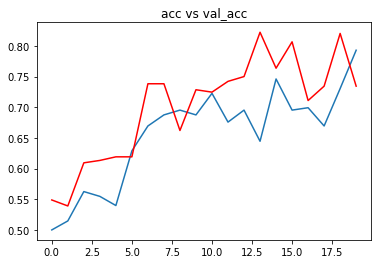

In [39]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')

plt.title("acc vs val_acc")
plt.show()

Train Loss vs Validation Loss

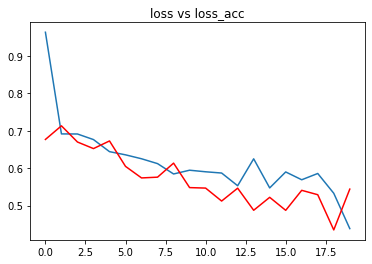

In [40]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')

plt.title("loss vs val_loss")
plt.show()

Importer le meilleur modèle

In [41]:

from keras.models import load_model

model = load_model('C:/Users/zied galbi/bestmodel.h5')

## Model Accuracy

In [42]:
acc = model.evaluate_generator(test_data)[1]

print(f"the accuracy of our model is {acc*100} %")

Instructions for updating:
Please use Model.evaluate, which supports generators.
the accuracy of our model is 80.41542768478394 %


la précision de notre modèle est de 80.415%.

## Model Testing  

In [43]:
from keras.preprocessing.image import load_img, img_to_array

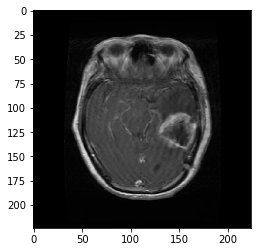

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
the MRI is having a Tumor


In [44]:
path = "C:/Users/zied galbi/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (619).jpg"

img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

pred = model.predict_classes(input_arr)[0][0]
pred

if pred==0:
    print("the MRI is having a Tumor")
else :
    print("the MRI is Not having a Tumor")
    

train_data.class_indices

# Transfer Learning

## Model Training with MobileNet pre-trained architecture 

In [48]:
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input

Préparer nos images pour MobileNet

In [49]:
def  preprocessingImages3(path):
    """
    input : path
    output : Pre processed images
    """
    image_data = ImageDataGenerator(zoom_range = 0.2, shear_range= 0.2, preprocessing_function = preprocess_input, horizontal_flip= True )  # data augmentation
    image = image_data.flow_from_directory(directory = path, target_size= (224,224), batch_size = 32, class_mode = 'binary')
    
    return image

In [50]:
def  preprocessingImages4(path):
    """
    input : path
    output : Pre processed images
    """
    image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
    image = image_data.flow_from_directory(directory = path, target_size= (224,224), batch_size = 32, class_mode = 'binary')
    
    return image

In [51]:
path = "C:/Users/zied galbi/train"
train_data_mobileNet = preprocessingImages3(path)



Found 3151 images belonging to 2 classes.


In [52]:
path = "C:/Users/zied galbi/val"
val_data_mobileNet = preprocessingImages4(path)



Found 674 images belonging to 2 classes.


In [53]:

path = "C:/Users/zied galbi/test"
test_data_mobileNet = preprocessingImages4(path)

Found 674 images belonging to 2 classes.


MobileNet Model

In [54]:
base_model = MobileNet(input_shape=(224,224,3), include_top = False)

17227776/17225924 [==============================] - 4s 0us/step


In [55]:
for layer in base_model.layers:
    layer.trainable = False

In [56]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

Ajouter une Dense layer à la fin du base model

In [59]:
X = Flatten()(base_model.output)
X = Dense(units = 1, activation = 'sigmoid')(X)

model_transLearn = Model(base_model.input, X)    # modéle composé 

In [60]:
model_transLearn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [61]:
# Compiler le nouveau modèle
model_transLearn.compile(optimizer= 'rmsprop', loss = keras.losses.binary_crossentropy, metrics=['accuracy'] )

In [62]:

# early stopping 

es_1 = EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01, patience= 3, verbose = 1)

# model check point

mc_1 = ModelCheckpoint(monitor = 'val_accuracy',filepath='C:/Users/zied galbi/bestmodel_transLearn_.h5' , verbose = 1, save_best_only= True)

cb_1 = [es_1, mc_1]

In [63]:
hs_1 = model_transLearn.fit_generator(generator = train_data_mobileNet,
                         steps_per_epoch = 8 ,
                         epochs = 30,
                         verbose = 1,
                         validation_data= val_data_mobileNet,
                         validation_steps= 16,
                         callbacks= cb_1)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 8.1026 - accuracy: 0.6094
Epoch 00001: val_accuracy improved from -inf to 0.84961, saving model to C:/Users/zied galbi\bestmodel_transLearn_.h5
8/8 [==============================] - 35s 4s/step - loss: 8.1026 - accuracy: 0.6094 - val_loss: 1.0876 - val_accuracy: 0.8496
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 3.0104 - accuracy: 0.6914
Epoch 00002: val_accuracy improved from 0.84961 to 0.86914, saving model to C:/Users/zied galbi\bestmodel_transLearn_.h5
8/8 [==============================] - 31s 4s/step - loss: 3.0104 - accuracy: 0.6914 - val_loss: 0.8235 - val_accuracy: 0.8691
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 1.0008 - accuracy: 0.8594
Epoch 00003: val_accuracy did not improve from 0.86914
8/8 [==============================] - 30s 4s/step - loss: 1.0008 - accuracy: 0.8594 - val_loss: 1.3932 - val_accuracy: 0.8125
Epoch 4/30
8/8 [==============================] -

In [64]:
# load the best model

model_transLearn = load_model('C:/Users/zied galbi/bestmodel_transLearn_.h5')

In [65]:
# Accuracy of our model

acc_1 = model_transLearn.evaluate_generator(test_data_mobileNet)[1]

print(f"the accuracy of our model is {acc_1*100} %")

the accuracy of our model is 94.21365261077881 %


accuracy inreased by 14% !!! From 80.41% to 94.21%

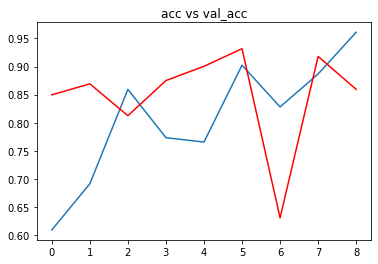

In [71]:
plt.plot(hs_1.history['accuracy'])
plt.plot(hs_1.history['val_accuracy'], c = 'red')

plt.title("acc vs val_acc")
plt.show()

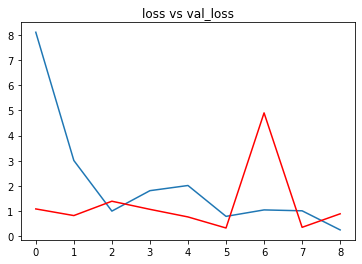

In [72]:
plt.plot(hs_1.history['loss'])
plt.plot(hs_1.history['val_loss'], c = 'red')

plt.title("loss vs val_loss")
plt.show()

the MRI is having a Tumor


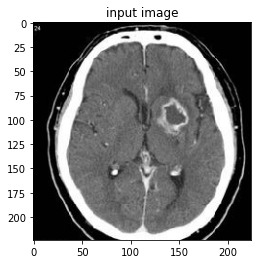

In [82]:
# path for the image to see if it predicts correct class

path_1 = "C:/Users/zied galbi/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (2310).jpg"

img_1 = load_img(path_1, target_size = (224,224))
i = img_to_array(img_1)/255



input_arr = np.array([i])  #expand dimension for proper model input
input_arr.shape

pred = np.argmax(model_transLearn.predict(input_arr))


if pred==0:
    print("the MRI is having a Tumor")
else :
    print("the MRI is Not having a Tumor")
    
# to display the image   
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()
    
    